# Modelo de Clasificación KNN

In [ ]:
import boto3
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tensorflow.keras import layers, models

# Parámetros S3
bucket_name = 'rawmattelsa'
folder_name = 'Fotos/'



# Función para cargar y preprocesar imágenes desde S3
def cargar_y_preprocesar_imagen_s3(ruta_completa):
    try:
        # Descargar el archivo desde S3
        response = s3.get_object(Bucket=bucket_name, Key=ruta_completa)
        imagen_bytes = response['Body'].read()

        # Decodificar la imagen
        imagen = tf.image.decode_image(imagen_bytes, channels=1)  # Convertir a RGB
        imagen = tf.image.resize(imagen, [64, 64])  # Ajustar tamaño
        imagen = tf.keras.utils.img_to_array(imagen)
        imagen = imagen / 255.0  # Normalizar

        return imagen
    except Exception as e:
        print(f"Error al cargar la imagen {ruta_completa}: {e}")
        return None

# Función para crear el modelo base convolucional
def crear_modelo_base(input_shape):
    # Usar el modelo funcional desde el principio
    inputs = layers.Input(shape=input_shape)  # Definir la entrada
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)  # Capa Conv2D
    x = layers.MaxPooling2D()(x)  # Capa MaxPooling
    x = layers.Flatten()(x)  # Aplanar las características
    x = layers.Dense(128, activation='relu')(x)  # Capa densa
    modelo_base = models.Model(inputs=inputs, outputs=x)  # Definir el modelo con entrada y salida
    return modelo_base

# Función para extraer características utilizando el modelo base
def extraer_caracteristicas(modelo, datos):
    return modelo.predict(datos, batch_size=32)

# Función de clustering KMeans
def clustering_kmeans(caracteristicas, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    etiquetas = kmeans.fit_predict(caracteristicas)
    return etiquetas, kmeans

# Función para asignar pseudoetiquetas a las imágenes
def asignar_pseudoetiquetas(datos, etiquetas):
    dataset_pseudo = tf.data.Dataset.from_tensor_slices((datos, etiquetas))
    dataset_pseudo = dataset_pseudo.batch(32).shuffle(buffer_size=1024)
    return dataset_pseudo

# Función para reentrenar el modelo con las pseudoetiquetas
def reentrenar_modelo(modelo_base, datos, n_clusters, epochs=10):
    # Obtener la salida del modelo base
    x = modelo_base.output

    # Añadir capa de clasificación
    salida = layers.Dense(n_clusters, activation='softmax')(x)

    # Crear el modelo final con la capa de clasificación
    modelo_final = models.Model(inputs=modelo_base.input, outputs=salida)

    # Compilar el modelo
    modelo_final.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo final con las pseudoetiquetas
    modelo_final.fit(datos, epochs=epochs)

    return modelo_final

# Función de entrenamiento iterativo DeepCluster
def deepcluster_iterativo(modelo_base, datos, n_clusters, iteraciones=5, epochs=10):
    for i in range(iteraciones):
        print(f"Iteración {i+1}/{iteraciones}")

        # 1. Extraer características del modelo base
        caracteristicas = extraer_caracteristicas(modelo_base, datos)

        # 2. Aplicar clustering KMeans
        etiquetas_pseudo, modelo_kmeans = clustering_kmeans(caracteristicas, n_clusters)

        # 3. Crear dataset con las pseudoetiquetas
        dataset_pseudo = asignar_pseudoetiquetas(datos, etiquetas_pseudo)

        # 4. Reentrenar el modelo con las pseudoetiquetas
        modelo_base = reentrenar_modelo(modelo_base, dataset_pseudo, n_clusters, epochs)

    return modelo_base, modelo_kmeans
# Generar DataFrame con rutas de fotos en S3
def generar_dataframe_s3(bucket_name, folder_name):
    try:
        response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_name)

        if 'Contents' in response:
            # Crear listas para las columnas
            rutas = []
            nombres = []

            for obj in response['Contents']:
                ruta_completa = obj['Key']  # Ruta completa
                if ruta_completa.endswith('/'):  # Saltar carpetas
                    continue
                rutas.append(ruta_completa)
                nombres.append(ruta_completa.split('/')[-1])  # Solo el nombre del archivo

            # Crear DataFrame
            df = pd.DataFrame({'ruta': rutas, 'nombre': nombres})
            print("DataFrame con rutas generado:")
            print(df.head())
            return df
    except Exception as e:
        print(f"Error al generar el DataFrame desde S3: {e}")
        return None

# Cargar las rutas de las imágenes
df = generar_dataframe_s3(bucket_name, folder_name)

# Dividir en entrenamiento y prueba
X = df['ruta']
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# Cargar las imágenes de entrenamiento
X_train_arrays = np.array([cargar_y_preprocesar_imagen_s3(ruta) for ruta in X_train])


# Crear el modelo base (CNN)
modelo_base = crear_modelo_base((64, 64, 1))

# Número de clusters
n_clusters = 2  # Puedes cambiar este valor según tus necesidades

# Entrenar el modelo DeepCluster
modelo_trabajado, modelo_kmeans = deepcluster_iterativo(modelo_base, X_train_arrays, n_clusters, iteraciones=5, epochs=10)


DataFrame con rutas generado:
                                ruta                 nombre
0  Fotos/FOTOS/IG-Jul-S2-2022-03.jpg  IG-Jul-S2-2022-03.jpg
1  Fotos/FOTOS/IG-Jul-S2-2022-04.jpg  IG-Jul-S2-2022-04.jpg
2  Fotos/FOTOS/IG-Jul-S2-2022-05.jpg  IG-Jul-S2-2022-05.jpg
3  Fotos/FOTOS/IG-Jul-S2-2022-06.jpg  IG-Jul-S2-2022-06.jpg
4  Fotos/FOTOS/IG-Jul-S2-2022-07.jpg  IG-Jul-S2-2022-07.jpg
Iteración 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.5227 - loss: 1.5618
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7590 - loss: 0.4915
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.8750 - loss: 0.3011
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9356 - loss: 0.1847
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9542 - loss: 0.1276
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9599 - loss: 0.1075
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms

In [ ]:
X_test_arrays = np.array([cargar_y_preprocesar_imagen_s3(ruta) for ruta in X_test])


predicciones = modelo_trabajado.predict(X_test_arrays)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [ ]:

# Obtener el índice del cluster con la mayor probabilidad para cada imagen
clases_predichas = np.argmax(predicciones, axis=1)

# Ahora 'clases_predichas' es un array con las etiquetas de clusters predichas para cada imagen
print(clases_predichas)  # Imprime las clases predichas

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


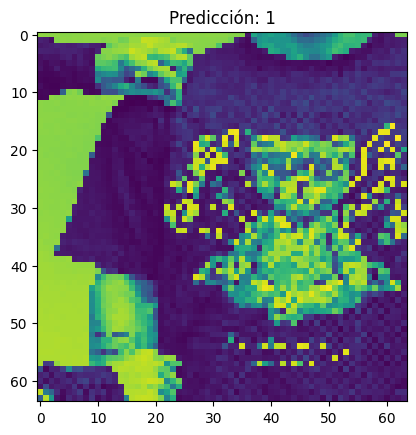

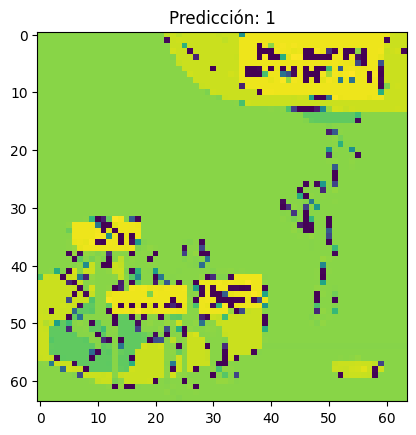

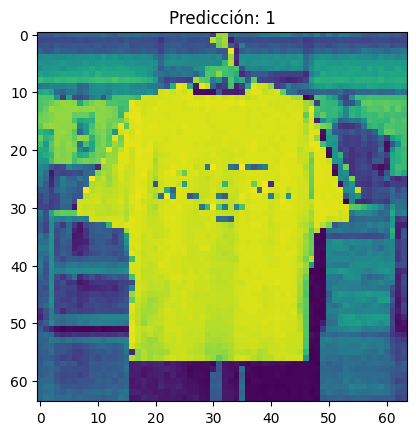

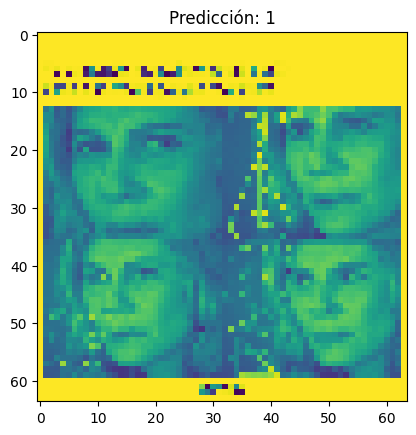

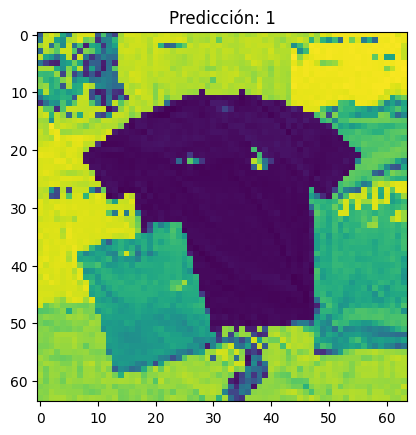

In [ ]:
import matplotlib.pyplot as plt

# Supongamos que tienes X_test y clases_predichas
# Aquí mostramos las primeras 5 imágenes con sus predicciones

for i in range(5):
    plt.imshow(X_test_arrays[i])  # Mostrar la imagen
    plt.title(f"Predicción: {clases_predichas[i]}")  # Título con la predicción
    plt.show()